In [1]:
using Pkg
Pkg.activate("../", io=devnull)

In [2]:
using VeryDiff
using LinearAlgebra
using Plots
using DataStructures
using Gurobi, JuMP

include("util.jl")

VeryDiff.NEW_HEURISTIC = false

Set parameter Username
Academic license - for non-commercial use only - expires 2026-11-30


false

In [53]:
function contract_zono(bounds::Matrix{Float64}, g::Vector{Float64}, c::Float64, direction::Int64)
    n, m = size(bounds)
    @assert m == 2 "Two endpoints are necessary to define interval bounds"
    @assert n == size(g, 1) "Dimension mismatch"
    @assert direction == 1 || direction == -1 "Unspecified direction"

    l = @view bounds[:, 1]
    u = @view bounds[:, 2]

    if direction == 1
        g, c = -g, -c
    end

    v = ifelse.(g .>= 0, l, u)

    if g' * v > -c
        return zeros(n, m)
    end

    for i in 1:n
        if g[i] != 0.0
            x = 1 / g[i] * (-c - v[1:i-1]'g[1:i-1] - v[i+1:end]'g[i+1:end])
            if g[i] > 0
                u[i] = min(u[i], x)
            else
                l[i] = max(l[i], x)
            end
        end
    end

    return bounds
end

contract_zono (generic function with 2 methods)

In [54]:
contract_zono([-1.0 1.0; -1.0 1.0], [2.0, 1.0], 0.0, 1)

2×2 Matrix{Float64}:
 -0.5  1.0
 -1.0  1.0

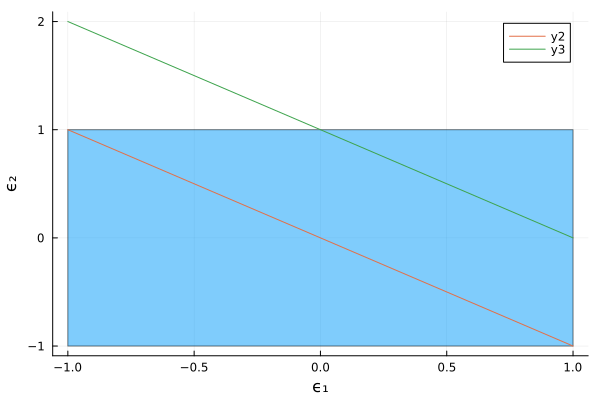

In [ ]:
Z₁ = Zonotope([1.0 0.0; 0.0 1.0], [0.0, 0.0], nothing)
# Z₂ = Zonotope([1.0 0.0 1.0; 0.0 0.0 1.0], [0.0, 0.0], nothing)

p = plot(dpi=500, xlims=(0, 100), ylims=(0, 120), widen=true, xguidefontsize=5, yguidefontsize=5, legend=:legend; layout=num_configs)

plot!(Z₁, alpha=0.5, xlabel="ϵ₁", ylabel="ϵ₂")
plot!(range(-1.0, 1.0, length=2), -range(-1.0, 1.0, length=2))
plot!(range(-1.0, 1.0, length=2), -range(-1.0, 1.0, length=2) .+ 1)
# plot!(Z₂)
# println(size(range(-1.0, 1.0, length=100)))

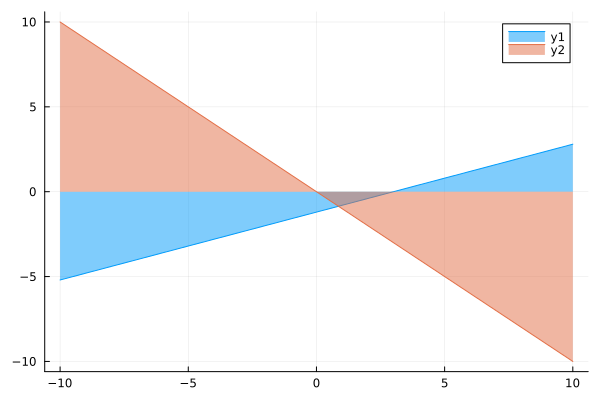

In [36]:
f(x) = (2/5)x-6/5
g(x) = -x
X = -10:10
the_max = max(f(X[end]), g(X[1]))

plot(X, f, fill = (0, 0.5, :auto))
plot!(X, g, fill = (0, 0.5, :auto))

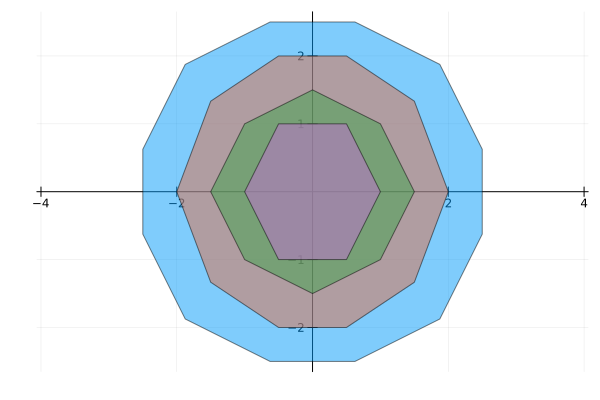

In [3]:
hexagon = Zonotope([0.25 0.5 0.25; -0.5 0.0 0.5], [0.0, 0.0], nothing)
octagon = Zonotope([-0.5 0.25 0.5 0.25; 0.25 -0.5 0.25 0.5], [0.0, 0.0], nothing)
decagon = Zonotope([4.0, 8 / 3] .* [0.125 -0.125 0.0625 0.125 0.0625; 0.125 0.125 -0.25 0.0 0.25], [0.0, 0.0], nothing)
dodecagon = Zonotope((5 / 4) * [0.0 0.5 -0.5 0.25 0.5 0.25; 0.5 0.25 0.25 -0.5 0.0 0.5], [0.0, 0.0], nothing)


plot(dodecagon, alpha=0.5, framestyle=:origin, aspect_ratio=:equal)
plot!(decagon, alpha=0.5, framestyle=:origin, aspect_ratio=:equal)
plot!(octagon, alpha=0.5, framestyle=:origin, aspect_ratio=:equal)
plot!(hexagon, alpha=0.5, framestyle=:origin, aspect_ratio=:equal)

Z₀: Zonotope([-0.5 0.0 0.25 0.0; 0.5 -0.5 0.0 0.5], [0.25, 0.5], nothing)
Z₁: Zonotope([-1.0 0.0 0.0; 0.5 -0.5 0.5], [0.0, 0.5], nothing)
Z₂: Zonotope([-0.0 0.0 0.0; 0.5 -0.5 0.5], [0.0, 0.5], nothing)


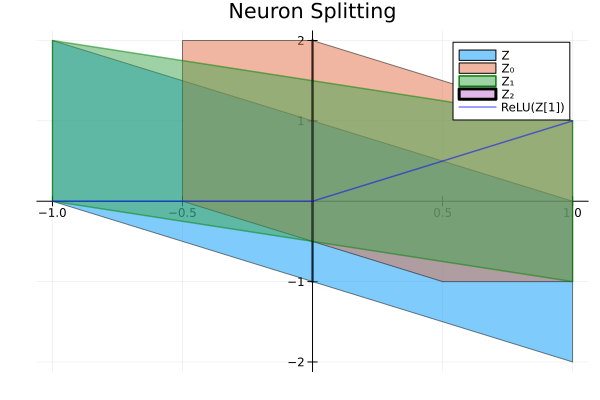

In [ ]:
linewidth = 1.5

relu = x -> max.(x, zero(x))

Z = Zonotope([-1.0 0.0; 1.0 -1.0], [0.0, 0.0], nothing)
bounds = zono_bounds(Z)
lower = bounds[:, 1]
upper = bounds[:, 2]

x = range.(lower, upper, length=1000)

Z₀ = ReLU()(Z, PropState(), 1, 1)
Z₁ = ReLU()(Z, PropState(SplitNode[SplitNode(1, 1, 1, 1)]), 1, 1)
Z₂ = ReLU()(Z, PropState(SplitNode[SplitNode(1, 1, 1, -1)]), 1, 1)

println("Z₀: $Z₀")
println("Z₁: $Z₁")
println("Z₂: $Z₂")

plot(Z, label="Z", framestyle=:origin, alpha=0.5, title="Neuron Splitting")
plot!(Z₀, label="Z₀", framestyle=:origin, alpha=0.5)
plot!(Z₁, label="Z₁", framestyle=:origin, alpha=0.5, lc=:green, lw=linewidth)
plot!(Z₂, label="Z₂", framestyle=:origin, alpha=0.5, lw=2*linewidth)
plot!(x[1], relu, label="ReLU(Z[1])", framestyle=:origin, alpha=0.5, lc=:blue, lw=linewidth)

In [ ]:
function is_epsilon_counterexample(ϵ)
    return (N₁, N₂, cex) -> begin
        return VeryDiff.get_sample_distance(N₁, N₂, cex) > ϵ
    end
end

In [ ]:
function plot_diff_zono(∂Z; title="Output")
    plot(∂Z.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title=title)
    plot!(∂Z.Z₂, label="Z₂", alpha=0.5)
    plot!(∂Z.∂Z, label="∂Z", alpha=0.5)
end

In [ ]:
function split_neuron(node :: SplitNode, prev_split :: Tuple{BitMatrix, Vector{SplitNode}})
    mask₁, split₁ = prev_split
    mask₂, split₂ = deepcopy(prev_split)

    push!(split₁, (SplitNode(node.network, node.layer, node.neuron, -1, node.g, node.c)))
    push!(split₂, (SplitNode(node.network, node.layer, node.neuron, 1, node.g, node.c)))

    return (mask₁, split₁), (mask₂, split₂)
end

In [ ]:
function propagate(Zin, prop_state)
    return N(Zin, prop_state), prop_state
end

In [ ]:
function search(N₁, N₂, Zin, Zout, prop_state, (mask, split_nodes))
    prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, Zin, Zout, nothing)
    
    if !prop_satisfied
        if !isnothing(cex)
            return VeryDiff.UNSAFE, cex[1]
        end

        split_nodes = prop_state.split_nodes
        # Initialize the LP solver
        model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
        set_time_limit_sec(model, 10)
        
        # Add variables and input and output constraints
        var_num = size(Zout.∂Z.G, 2)
        @variable(model, -1.0 <= x[1:var_num] <= 1.0)

        # Add split constraints
        Gₛ = zeros(Float64, size(split_nodes, 1), var_num)
        cₛ = zeros(Float64, size(split_nodes))
        dₛ = zeros(Float64, size(split_nodes))
        for (i, split_node) in enumerate(split_nodes)
            Gₛ[i, 1:size(split_node.g, 1)] = split_node.g
            cₛ[i] = split_node.c
            dₛ[i] = split_node.direction
        end
        @constraint(model, dₛ .* (Gₛ * x + cₛ) .>= 0.0)

        bounds = zono_bounds(Zout.∂Z)
        # Compute all output dimensions that still need to be proven
        mask = hcat(bounds[:, 1] .< -epsilon, bounds[:, 2] .> epsilon) .&& (isempty(mask) ? true : mask)

        # For each unproven output dimension we solve a LP for corresponding lower and upper bound
        # for i in sort!((1:size(mask, 1))[mask[:, 1] .|| mask[:, 2]], by=k->sum(abs.(bounds[k, :])))
        for i in (1:size(mask, 1))[mask[:, 1] .|| mask[:, 2]]
            for (j, σ) in [(1, -1), (2, 1)][mask[i, :]]

                @objective(model, Max, σ * (Zout.∂Z.G[i, :]' * x + Zout.∂Z.c[i]))
                optimize!(model)

                if is_solved_and_feasible(model)
                    cex = Zin.Z₁.G * value.(x)[1:input_dim] + Zin.Z₁.c
                    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
                    if sample_distance > epsilon
                        return VeryDiff.UNSAFE, cex
                    end
                end

                mask[i, j] = termination_status(model) != MOI.INFEASIBLE
            end
        end

        if any(mask)
            return VeryDiff.UNKNOWN, nothing
        end
    end

    return VeryDiff.SAFE, nothing
end

In [ ]:
function branch_and_bound(splits, split, split_candidate)
    split₁, split₂ = split_neuron(split_candidate, split)
    push!(splits, split₁, split₂)
end

In [ ]:
W1 = [1.0 1.0; 1.0 -1.0]
b1 = zeros(2)
W2 = [1.0 1.0; 1.0 -1.0]
b2 = [-0.5, 0.0]
W3 = [-1.0 0.0; 1.0 1.0]
b3 = zeros(2)

layers1 = [Dense(W1, b1), ReLU(), Dense(W2, b2), ReLU(), Dense(W3, b3)]

W1a = [1.0 1.1; 1.0 -0.9]
b1a = zeros(2)
W2a = [1.1 1.0; 0.9 -1.0]
b2a = [-0.4, 0.0]
W3a = [-1.0 0.0; 1.0 1.1]
b3a = zeros(2)

layers2 = [Dense(W1a, b1a), ReLU(), Dense(W2a, b2a), ReLU(), Dense(W3a, b3a)]

In [ ]:
epsilon = 0.2
property_check = get_epsilon_property(epsilon)
is_counterexample = is_epsilon_counterexample(epsilon)

N₁ = Network(layers1)
N₂ = Network(layers2)
N = GeminiNetwork(N₁, N₂)

Z = Zonotope([1.0 0.0; 0.0 1.0], zeros(2), I(2))
∂Z = Zonotope(zeros(Float64, size(Z.G)), zeros(size(Z.c)), nothing)
Zin = DiffZonotope(Z, deepcopy(Z), ∂Z, 0, 0, 0)

input_dim = size(Z.G, 2)

splits = Deque{Tuple{BitMatrix, Vector{SplitNode}}}()
push!(splits, (hcat(falses(0), falses(0)), SplitNode[]))

neuron_splits = 0

In [ ]:
split = popfirst!(splits)
split₁, split₂ = split_neuron(SplitNode(1, 1, 1, 0), split)
push!(splits, split₂, split₁)

In [ ]:
mask, split_nodes = popfirst!(splits)
Zout, prop_state = propagate(Zin, PropState(split_nodes))
split_nodes

In [ ]:
plot_diff_zono(Zout)

In [ ]:
_status, cex = search(N₁, N₂, Zin, Zout, prop_state, (mask, split_nodes))

In [ ]:
if _status == VeryDiff.UNKNOWN
    branch_and_bound(splits, (mask, split_nodes), prop_state.split_candidate)
    neuron_splits += 1
end

In [ ]:
mask, split_nodes = popfirst!(splits)
Zout, prop_state = propagate(Zin, PropState(split_nodes))
split_nodes

In [ ]:
plot_diff_zono(Zout)

In [ ]:
_status, cex = search(N₁, N₂, Zin, Zout, prop_state, (mask, split_nodes))

In [ ]:
if _status == VeryDiff.UNKNOWN
    branch_and_bound(splits, (mask, split_nodes), prop_state.split_candidate)
    neuron_splits += 1
end

In [ ]:
mask, split_nodes = popfirst!(splits)
Zout,prop_state = propagate(Zin, PropState(split_nodes))
split_nodes

In [ ]:
plot_diff_zono(Zout)

In [ ]:
_status, cex = search(N₁, N₂, Zin, Zout, prop_state, (mask, split_nodes))

In [ ]:
if _status == VeryDiff.UNKNOWN
    branch_and_bound(splits, (mask, split_nodes), prop_state.split_candidate)
    neuron_splits += 1
end

In [ ]:
mask, split_nodes = popfirst!(splits)
Zout, prop_state = propagate(Zin, PropState(split_nodes))
split_nodes

In [ ]:
plot_diff_zono(Zout)

In [ ]:
_status, cex = search(N₁, N₂, Zin, Zout, prop_state, (mask, split_nodes))